In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from sklearn.utils import shuffle
from tensorflow.keras import utils
from tensorflow import concat
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

2023-10-05 01:46:36.393568: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-05 01:46:36.457415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 01:46:37.174474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
    
images = images.astype(np.float32)    

labels = utils.to_categorical(labels, 10)
labels = labels.astype(np.float32)

In [3]:
(images, labels) = shuffle(images, labels)

In [4]:
classes = ['Disturbed Galaxies','Merging Galaxies','Round Smooth Galaxies','In-between Round Smooth Galaxies','Cigar Shaped Smooth Galaxies','Barred Spiral Galaxies','Unbarred Tight Spiral Galaxies','Unbarred Loose Spiral Galaxies','Edge-on Galaxies without Bulge','Edge-on Galaxies with Bulge']
class_labels = {classes:i for classes, i in enumerate(classes)}
print(class_labels)

{0: 'Disturbed Galaxies', 1: 'Merging Galaxies', 2: 'Round Smooth Galaxies', 3: 'In-between Round Smooth Galaxies', 4: 'Cigar Shaped Smooth Galaxies', 5: 'Barred Spiral Galaxies', 6: 'Unbarred Tight Spiral Galaxies', 7: 'Unbarred Loose Spiral Galaxies', 8: 'Edge-on Galaxies without Bulge', 9: 'Edge-on Galaxies with Bulge'}


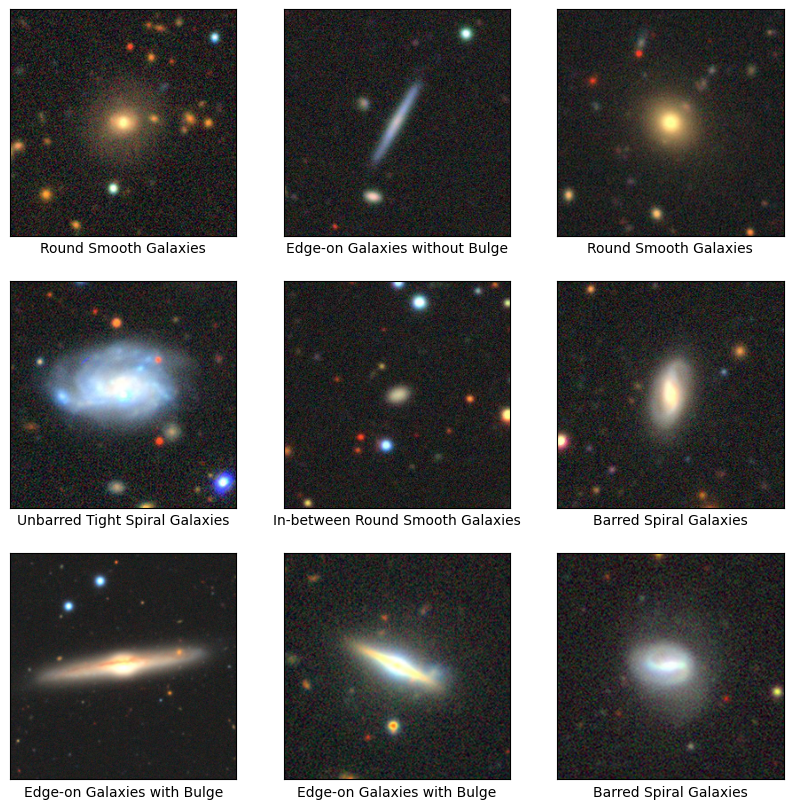

In [5]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i]/255.)
    plt.xlabel(class_labels[int(np.argwhere(labels[i]==1))])
plt.show()

In [6]:
train_datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1/255.,
    validation_split=0.2,)

train_datagen.fit(images)

In [7]:
class SeBlock(Model):
    def __init__(self, planes):
        super(SeBlock, self).__init__()
        self.se = Sequential()
        self.se.add(GlobalAveragePooling2D(keepdims=True))
        self.se.add(Conv2D(planes,kernel_size=(1,1),strides=(1, 1),padding='same'))
        self.se.add(Activation('relu'))
        self.se.add(Conv2D(planes,kernel_size=(1,1),strides=(1, 1),padding='same'))
        self.se.add(Activation('sigmoid'))
    def call(self, inputs):
        out = self.se(inputs)
        return out

In [8]:
class BasicBlock(Model):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.basic = Sequential()
        self.basic.add(Conv2D(planes,kernel_size=(3,3),strides=(stride, stride),padding='same')) 
        self.basic.add(BatchNormalization())
        self.basic.add(Activation('relu'))
        self.basic.add(Conv2D(planes,kernel_size=(3,3),strides=(1, 1),padding='same'))
        self.basic.add(BatchNormalization())
        self.se1 = SeBlock(planes=planes)
        self.shortcut = Sequential()
        if in_planes!=planes or stride!=1:
            self.shortcut.add(Conv2D(planes,kernel_size=(1,1),strides=(stride, stride),padding='same'))
            self.shortcut.add(BatchNormalization())
        self.a2 = Activation('relu')
    def call(self, inputs):
        out = self.basic(inputs)
        w = self.se1(out)
        out = out * w
        residual=self.shortcut(inputs)
        out = self.a2(residual+out)
        return out

In [9]:
class Root(Model):
    def __init__(self, planes, kernel_size=1):
        super(Root, self).__init__()
        self.basic = Sequential()
        self.basic.add(Conv2D(planes,kernel_size=(kernel_size,kernel_size),strides=(1, 1),padding='same'))
        self.basic.add(BatchNormalization())
        self.basic.add(Activation('relu'))
    def call(self, inputs):
        out = concat(inputs, axis=-1)
        out = self.basic(out)
        return out

In [10]:
class Tree(Model):
    def __init__(self, in_planes, planes, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(planes)
            self.left_node = BasicBlock(in_planes, planes, stride=stride)
            self.right_node = BasicBlock(planes, planes, stride=1)
        else:
            self.root = Root(planes)
            self.subtrees={}
            for i in reversed(range(1, level)):
                if i==level-1:
                    subtree = Tree(in_planes, planes, level=i, stride=stride)
                else:
                    subtree = Tree(planes, planes, level=i, stride=stride)
                self.subtrees[f'level_{i}'] = subtree
            self.prev_root = BasicBlock(in_planes, planes, stride=stride)
            self.left_node = BasicBlock(planes, planes, stride=1)
            self.right_node = BasicBlock(planes, planes, stride=1)
    def call(self, inputs):
        out = inputs
        outs = [self.prev_root(out)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.subtrees[f'level_{i}']
            out = level_i(out)
            outs.append(out)
        out = self.left_node(out)
        outs.append(out)
        out = self.right_node(out)
        outs.append(out)
        out = self.root(outs)
        return out

In [11]:
class CNN_net(Model):
    def __init__(self, modle):
        super(CNN_net, self).__init__()
        self.stem = Sequential()
        self.stem.add(Conv2D(16,kernel_size=(3,3),strides=(1, 1),padding='same'))#256
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('relu'))
        self.stem.add(Conv2D(32,kernel_size=(3,3),strides=(1, 1),padding='same'))#256
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('relu'))
        self.stem.add(Conv2D(32,kernel_size=(3,3),strides=(2, 2),padding='same'))#128
        self.stem.add(BatchNormalization())
        self.stem.add(Activation('relu'))
        
        self.blocks = Sequential()
        self.blocks.add(Tree(32,  64, level=2, stride=1))##128
        self.blocks.add(Tree(64,  128, level=2, stride=2))#64
        self.blocks.add(Tree(128,  256, level=2, stride=2))#32
        self.blocks.add(Tree(256,  512, level=2, stride=2))#16
        self.blocks.add(Tree(512,  1024, level=2, stride=2))#8
        self.blocks.add(Tree(1024,  2048, level=2, stride=2))#4
        
        self.fullconnected = Sequential()
        self.fullconnected.add(GlobalMaxPooling2D())
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        self.fullconnected.add(Dense(1024, activation='linear'))
        self.fullconnected.add(BatchNormalization())
        self.fullconnected.add(Activation('tanh'))
        
        self.out = Sequential()
        if model=='regression':
            self.out.add(Dense(1, activation='linear'))
        if model=='classification':
            self.out.add(Dense(10, activation='softmax'))
        
    def call(self, inputs):
        out = self.stem(inputs)
        out = self.blocks(out)
        out = self.fullconnected(out)
        out = self.out(out)
        return out

In [ ]:
#checkpoint_save_path = r'saved_modle_classification'
modle_classification = CNN_net(model='classification')
initial_learning_rate = 0.1
first_decay_steps = 1000
t_mul = 2.0
m_mul = 1.0
alpha = 0.0
lr_reducer = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha)
modle_classification.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=lr_reducer,momentum=0.9,nesterov=True,weight_decay=5e-4),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=tf.keras.metrics.CategoricalAccuracy())
#checkpointer = ModelCheckpoint(filepath=checkpoint_save_path,monitor='val_loss',verbose=0,save_best_only=True,save_weights_only=False)
history_classification = modle_classification.fit(train_datagen.flow(images, labels, batch_size=16,subset='training'),
                                                    validation_data=train_datagen.flow(images, labels,batch_size=16, subset='validation'),
                                                    steps_per_epoch=880,
                                                    epochs=400,
                                                    #callbacks=[checkpointer,lr_reducer]
                                                 )
modle_classification.summary()

2023-10-05 01:47:55.264462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 01:47:55.310864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 01:47:55.311443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/400


2023-10-05 01:48:42.063245: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc0586b31c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 01:48:42.063825: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-05 01:48:42.164405: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


880/880 [==============================] - 411s 401ms/step - loss: 3.2667 - categorical_accuracy: 0.1369 - val_loss: 2.2092 - val_categorical_accuracy: 0.1686
Epoch 2/400
880/880 [==============================] - 344s 391ms/step - loss: 2.9930 - categorical_accuracy: 0.1486 - val_loss: 2.9026 - val_categorical_accuracy: 0.1153
Epoch 3/400
880/880 [==============================] - 344s 391ms/step - loss: 2.3238 - categorical_accuracy: 0.2053 - val_loss: 2.0957 - val_categorical_accuracy: 0.2365
Epoch 4/400
880/880 [==============================] - 345s 392ms/step - loss: 2.4416 - categorical_accuracy: 0.2062 - val_loss: 2.1523 - val_categorical_accuracy: 0.1669
Epoch 5/400
880/880 [==============================] - 345s 392ms/step - loss: 2.2286 - categorical_accuracy: 0.2106 - val_loss: 2.0526 - val_categorical_accuracy: 0.2301
Epoch 6/400
880/880 [==============================] - 344s 391ms/step - loss: 2.0449 - categorical_accuracy: 0.2187 - val_loss: 2.0792 - val_categorical_acc

In [ ]:
fig1 = plt.figure(num="model regularize", figsize=(8, 6))
ax1 = fig1.add_subplot(111)
ax1.plot(history_classification.history['loss'], label="train loss", color='r')
ax1.plot(history_classification.history['val_loss'], label="val loss", color='y')
ax1.legend(loc=2)
ax1.set_ylabel('loss');
ax1.legend(loc = 'lower center')
plt.show()